## Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
# Load the Data into variable df

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
# TEST SAMPLE
df = pd.read_csv("data/train.csv")
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [5]:
test_df.shape, df.shape

((100, 12), (691, 12))

In [6]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [7]:
print(df.shape, start_df.shape)

(591, 12) (100, 12)


In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [9]:
from sklearn import preprocessing
df['Sex'] = preprocessing.LabelEncoder().fit_transform(df['Sex'])

df['Embarked'] = preprocessing.LabelEncoder().fit_transform(df['Embarked'])

df[['Sex','Embarked']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sex       591 non-null    int64
 1   Embarked  591 non-null    int64
dtypes: int64(2)
memory usage: 13.9 KB


In [132]:
test_df
test_df['Sex'] = preprocessing.LabelEncoder().fit_transform(test_df['Sex'])

test_df['Embarked'] = preprocessing.LabelEncoder().fit_transform(test_df['Embarked'])

test_df[['Sex','Embarked']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 709 to 321
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sex       100 non-null    int64
 1   Embarked  100 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB


In [133]:
start_df['Sex'] = preprocessing.LabelEncoder().fit_transform(start_df['Sex'])

start_df['Embarked'] = preprocessing.LabelEncoder().fit_transform(start_df['Embarked'])

start_df[['Sex','Embarked']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 288 to 330
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sex       100 non-null    int64
 1   Embarked  100 non-null    int64
dtypes: int64(2)
memory usage: 2.3 KB


### preprocessing & functions

In [10]:
def process_df(df):
    """ returns X, y """
    df['Sex'] = preprocessing.LabelEncoder().fit_transform(df['Sex'])
    df['Embarked'] = preprocessing.LabelEncoder().fit_transform(df['Embarked'])
    return (df[['Sex','Pclass','Embarked']], df['Survived'])

In [11]:
def print_metrics(y_test, y_pred):
    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

In [38]:
def reset_dfs(clf, df, start_df):
    # rest of df - find most unsure 
    df_X, df_y = process_df(df)
#     y_proba = clf.predict_proba(df[['Sex','Pclass','Embarked']])
#     y_test = df['Survived']
    y_proba = clf.predict_proba(df_X)

    
    diff = []
    for i in range(len(y_proba[:,0])):
        difference = abs(y_proba[i][0] - y_proba[i][1])
        diff.append(difference)
    top_10_idx = np.argsort(diff)[::-1][-10:] # least difference
    top_10_values = [diff[i] for i in top_10_idx]
    print(top_10_values[0])
    
    start_df = start_df.append(df.iloc[top_10_idx])
    df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]
    return(df, start_df)
    

### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

In [13]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.3,random_state=109)

In [59]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [60]:
# reload data to debug

# TEST SAMPLE
df = pd.read_csv("data/train.csv")
print(df.shape)
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

(891, 12)


In [61]:
df.shape, start_df.shape, test_df.shape

((691, 12), (100, 12), (100, 12))

In [62]:
X, y = process_df(start_df)

clf = svm.SVC(probability=True)
clf.fit(X, y)

X_test, y_test = process_df(test_df)
y_pred = clf.predict(X_test)

print_metrics(y_test, y_pred)

Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 0.75


In [63]:
df.shape, start_df.shape, test_df.shape

((691, 12), (100, 12), (100, 12))

In [43]:
# df, start_df = reset_dfs(clf, df, start_df)
# df.shape, start_df.shape, test_df.shape

In [44]:
df, start_df = reset_dfs(clf, df, start_df)

X, y = process_df(start_df)

clf = svm.SVC(probability=True)
clf.fit(X, y)

X_test, y_test = process_df(test_df)
y_pred = clf.predict(X_test)

print_metrics(y_test, y_pred)
print(df.shape, start_df.shape, test_df.shape)

0.23008063506040538
Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 0.75
(681, 12) (110, 12) (100, 12)


In [54]:
df, start_df = reset_dfs(clf, df, start_df)

X, y = process_df(start_df)

clf = svm.SVC(probability=True)
clf.fit(X, y)

X_test, y_test = process_df(test_df)
y_pred = clf.predict(X_test)

print_metrics(y_test, y_pred)
print(df.shape, start_df.shape, test_df.shape)

0.44863561520930834
Accuracy: 0.79
Precision: 0.7435897435897436
Recall: 0.725
(581, 12) (210, 12) (100, 12)


In [30]:
df.shape, start_df.shape, test_df.shape

((441, 12), (350, 12), (100, 12))

In [64]:
acc = []
prec=[]
recall=[]
for i in range(25):

    df, start_df = reset_dfs(clf, df, start_df)

    X, y = process_df(start_df)

    clf = svm.SVC(probability=True)
    clf.fit(X, y)

    X_test, y_test = process_df(test_df)
    y_pred = clf.predict(X_test)
    
    acc.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))

#     print_metrics(y_test, y_pred)

0.2363336399691836
0.10927798075077472
0.0868380816455892
0.24125527566899152
0.36689088123575786
0.36102967250361667
0.37515278300374516
0.3066418850736446
0.5001434583012812
0.4542115272029928
0.49803676943010916
0.5397569719865802
0.5412319890170434
0.5594954908322441
0.5089433558809597
0.3357705536942531
0.5614534172618122
0.5645900063469922
0.5698864278802016
0.5261135037539107
0.5211261003807899
0.5349428770725543
0.542033273877728
0.5473251815964444
0.5483457757298549


In [66]:
acc

[0.75,
 0.75,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79,
 0.79]

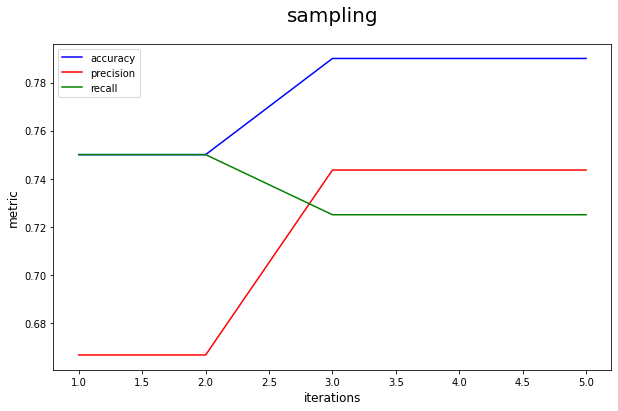

In [83]:
import matplotlib.pyplot as plt
import numpy as np
# x = list(range(1, 26))

# y1 = acc
# y2 = prec
# y3 = recall

x = list(range(1, 6))

y1 = acc[:5]
y2 = prec[:5]
y3 = recall[:5]

len(x), len(y1)

fig, ax = plt.subplots(figsize = (10,6))


ax.plot(x,y1,'blue', label="accuracy")
ax.plot(x,y2,'red', label='precision')
ax.plot(x,y3,'green', label='recall')

ax.set_ylabel('metric', fontsize=12)
ax.set_xlabel('iterations', fontsize=12)
ax.set_title('re-sampling', fontsize=20, y=1.05)
ax.legend(loc='best')

# plt.legend()

plt.show()

In [96]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

X = start_df[['Sex','Pclass','Embarked']]
y = start_df['Survived']

clf = svm.SVC(probability=True)
clf.fit(X, y)


SVC(probability=True)

In [97]:
from sklearn import metrics

y_pred = clf.predict(test_df[['Sex','Pclass','Embarked']])
y_test = test_df['Survived']

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 0.75


In [98]:
# rest of df - find most unsure 
y_proba = clf.predict_proba(df[['Sex','Pclass','Embarked']])
y_test = df['Survived']

diff = []
for i in range(len(y_proba[:,0])):
    difference = abs(y_proba[i][0] - y_proba[i][1])
    diff.append(difference)
top_10_idx = np.argsort(diff)[::-1][-10:] # least difference
top_10_values = [diff[i] for i in top_10_idx]

In [99]:
top_10_values

[0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.2482545893615033,
 0.11972117309630476]

In [100]:
# update start_df and df
df.iloc[top_10_idx]

start_df.append(df.iloc[top_10_idx])
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [73]:
process_df(df)
fit_start_df(start_df)
predict_test_df(test_df)

array([375, 399, 171, 412, 155, 154, 658, 424, 447, 553])

691